<a href="https://colab.research.google.com/github/Firojpaudel/GenAI-Chronicles/blob/main/GANs/cGAN_With_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **cGAN Implementation using PyTorch**: MNIST Dataset

---

In [3]:
## Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [4]:
## Hyperparameters and configs
n_epochs = 200
num_classes= 10
batch_size = 64
latent_dim = 100
img_size= 28
b1= 0.5
b2= 0.999
lr= 0.001 #Initial testing learning rate
channels = 1
sample_interval = 938

## Image shape
image_shape = (channels, img_size, img_size)

In [5]:
## GPU Test:
cuda = torch.cuda.is_available()
cuda

True

In [6]:
### Creating the directory for saving the images
if os.path.exists('images'):
  shutil.rmtree('images')   ## will delete the directory and its contents
os.makedirs("images", exist_ok= True)

#### 1. Creating the generator

In [7]:
#@ Samilar as in the basic GAN: so just copying the stuffs

class Generator(nn.Module):
  def __init__(self, latent_dim, img_shape):
    super(Generator, self).__init__()
    self.img_shape = img_shape
    self.label_embedding = nn.Embedding(num_classes, num_classes)

    def block(in_features, out_features, normalize= True):
      layers = [nn.Linear(in_features, out_features)]
      if normalize:
        layers.append(nn.BatchNorm1d(out_features, momentum=0.8))
      layers.append(nn.LeakyReLU(0.2, inplace= True))
      return layers

    self.model= nn.Sequential(
        *block(latent_dim + num_classes, 128, normalize = False),
        *block(128, 256),
        *block(256, 512),
        *block(512, 1024),
        nn.Linear(1024, int(np.prod(img_shape))),  #Trying to match with the dimension of the image and then we apply the activation function
        nn.Tanh()
    )


  def forward(self, z, labels):
    z= torch.cat((z, self.label_embedding(labels)), dim=1)
    img = self.model(z)
    return img.view(img.size(0), *self.img_shape)

**Difference with the basicGAN**

---
The main difference is that in a conditional GAN, the generator takes in both a random vector and additional information (like labels) to generate images, allowing for more control over the generated output, unlike a basic GAN which only uses a random vector.

#### 2. Creating the discriminator


In [8]:
class Discriminator(nn.Module):
  def __init__(self, img_shape):
    super(Discriminator, self).__init__()
    self.label_embedding = nn.Embedding(num_classes, num_classes)

    self.model= nn.Sequential(
        nn.Linear(int(np.prod(img_shape))+num_classes, 512),
        nn.LeakyReLU(0.2, inplace= True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace= True),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, img, labels):
    img_flat = img.view(img.size(0), -1)
    d_in = torch.cat((img_flat, self.label_embedding(labels)), dim=1)
    return self.model(d_in)


**The difference with the before model?**

---
Similar to the Generator evolution, we now have labels embeddings and are concatenating the flattened image with the embeddings.

#### 3. Initialization

In [9]:
generator = Generator(latent_dim= latent_dim, img_shape= image_shape)
discriminator = Discriminator(img_shape= image_shape)

#### 4. CUDA switch

In [10]:
if cuda:
  generator.cuda()
  discriminator.cuda()

#### 5. Optimizers creation

In [11]:
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas= (b1, b2))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas= (b1, b2))

#### 6. Dataset Preparation

In [12]:
dataloader= DataLoader(
    datasets.MNIST(
        "./data/MNIST",
        train= True,
        download= True,
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    ),
    batch_size = batch_size,
    shuffle= True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.31MB/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.49MB/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



#### 7. BCE Loss

In [13]:
adversarial_loss = torch.nn.BCELoss()
if cuda:
  adversarial_loss.cuda()

#### X. The Training Loop


In [14]:
## Type of Tensor
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [15]:
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        labels = Variable(labels.type(Tensor).long())

        # Train Generator
        optimizer_g.zero_grad()

        # Sample noise and labels
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        gen_labels = Variable(torch.randint(0, num_classes, (imgs.shape[0],)).type(Tensor).long())

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)

        g_loss.backward()
        optimizer_g.step()

        # Train Discriminator
        optimizer_d.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_d.step()

        ##@ Logging:
        print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}]"
              f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        ##@ Saving the generated outputs...
        if i % sample_interval == 0:
            # Generate specific label outputs (e.g., all ones)
            fixed_label = torch.tensor([1] * 25, dtype=torch.long).to(labels.device)
            z_fixed = Variable(Tensor(np.random.normal(0, 1, (25, latent_dim))))
            gen_imgs_fixed = generator(z_fixed, fixed_label)

            save_image(gen_imgs_fixed.data, f"images/label_1_epoch_{epoch}_batch_{i}.png", nrow=5, normalize=True)


print("Training Complete! Check the 'images' folder for the outputs")

<ipython-input-15-c6994a7017b3>:4: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)


Streaming output truncated to the last 5000 lines.
[Epoch 194/200] [Batch 629/938][D loss: 0.0789] [G loss: 4.6212]
[Epoch 194/200] [Batch 630/938][D loss: 0.1845] [G loss: 1.8782]
[Epoch 194/200] [Batch 631/938][D loss: 0.2233] [G loss: 6.5382]
[Epoch 194/200] [Batch 632/938][D loss: 0.0977] [G loss: 4.9696]
[Epoch 194/200] [Batch 633/938][D loss: 0.1149] [G loss: 3.5647]
[Epoch 194/200] [Batch 634/938][D loss: 0.1765] [G loss: 4.4799]
[Epoch 194/200] [Batch 635/938][D loss: 0.0675] [G loss: 5.7743]
[Epoch 194/200] [Batch 636/938][D loss: 0.2867] [G loss: 3.9581]
[Epoch 194/200] [Batch 637/938][D loss: 0.2987] [G loss: 5.3163]
[Epoch 194/200] [Batch 638/938][D loss: 0.2020] [G loss: 5.3801]
[Epoch 194/200] [Batch 639/938][D loss: 0.2785] [G loss: 3.0988]
[Epoch 194/200] [Batch 640/938][D loss: 0.2940] [G loss: 7.1883]
[Epoch 194/200] [Batch 641/938][D loss: 0.2896] [G loss: 4.7014]
[Epoch 194/200] [Batch 642/938][D loss: 0.2705] [G loss: 3.2014]
[Epoch 194/200] [Batch 643/938][D loss:

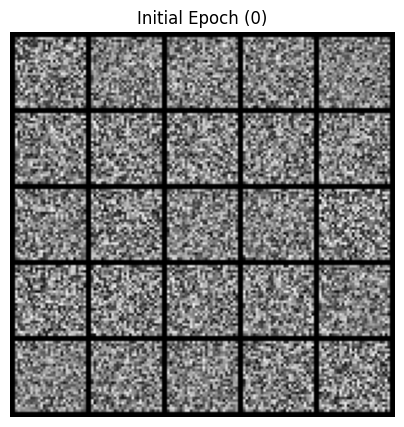

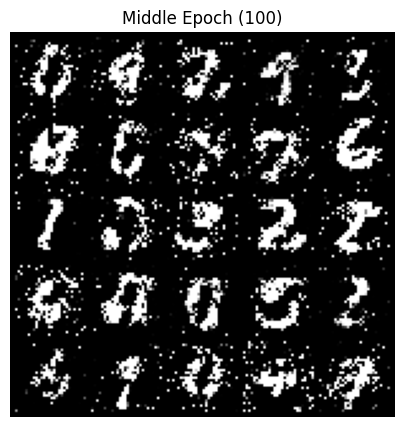

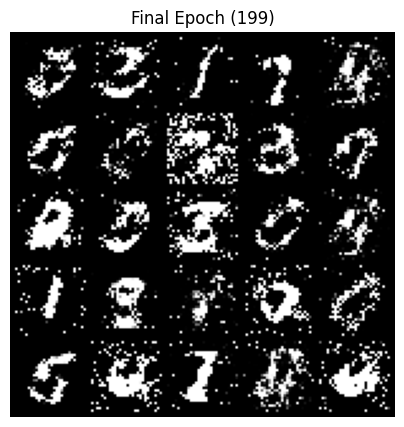

In [16]:
##@ Inspecting the generated images quality over time:

#defining the path first:
initial_path = "images/label_1_epoch_0_batch_0.png"
middle_path = f"images/label_1_epoch_{n_epochs // 2}_batch_0.png"
final_path = f"images/label_1_epoch_{n_epochs-1}_batch_0.png"

# Function to load and display an image from a file path
def show_image(image_path, title="Image"):
    if os.path.exists(image_path):
        img = mpimg.imread(image_path)
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
        plt.show()
    else:
        print(f"Image not found: {image_path}")

# Display initial, middle, and final images
show_image(initial_path, title="Initial Epoch (0)")
show_image(middle_path, title=f"Middle Epoch ({n_epochs // 2})")
show_image(final_path, title=f"Final Epoch ({n_epochs - 1})")

Well, I just tried to generate images with label `1`. But we could as well as provide the input for the label in the training loop itself.

For me, I didn't want to run that number of epochs. So, I sticked with the current approach.

---
However, if you want to, change the code snippet for save section in training loop as:

```python
label_value = int(input("Enter the label class from 0 to 9:" ))
##@ Saving the generated outputs...
        if i % sample_interval == 0:
            # Generate specific label outputs (e.g., all ones)
            fixed_label = torch.tensor([label_value] * 25,\
                          dtype=torch.long).to(labels.device)
            z_fixed = Variable(Tensor(np.random.normal(0, 1, (25, latent_dim))))
            gen_imgs_fixed = generator(z_fixed, fixed_label)

            save_image(gen_imgs_fixed.data, \
                      f"images/label_{label_value}_epoch_{epoch}_batch_{i}.png", \
                      nrow=5, normalize=True)

```